In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import copy, math

In [2]:
mnist = fetch_openml('mnist_784', version=1)
data = mnist.data
labels = labels = mnist.target.astype(int)  # Convert labels to integers
scaler = StandardScaler()
datas = np.array(data)
x = scaler.fit_transform(datas)
y = np.array(labels)

In [3]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_small, _, y_small, _ = train_test_split(x, y, train_size=2000, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_small, y_small, test_size=0.3, random_state=42)


### this is scikit learn approach

In [4]:
pca = PCA(n_components=50)  # Try 50 components to speed things up
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

In [5]:
svc = SVC(verbose=True)

In [6]:
svc.fit(x_train_pca,y_train)

[LibSVM]

SVC(verbose=True)

In [7]:
trainScore = svc.score(x_train_pca,y_train)
testScore =  svc.score(x_test_pca,y_test)

In [8]:
print(trainScore)
print(testScore)

0.9635714285714285
0.9016666666666666


### this is my custom approach

In [9]:
def predict(x, w_list, b_list):
    # x: The input data to classify (shape: n_samples, n_features)
    # w_list: List of weight vectors for each class (shape: n_classes, n_features)
    # b_list: List of bias terms for each class (shape: n_classes)
    
    # Get the decision values for each class
    decision_values = np.zeros((x.shape[0], len(w_list)))  # Shape: (n_samples, n_classes)
    
    # Calculate the decision value (w * x + b) for each class
    for i in range(len(w_list)):
        decision_values[:, i] = np.dot(x, w_list[i]) + b_list[i]
    
    # Predict the class with the highest decision value
    predictions = np.argmax(decision_values, axis=1)  # Get the class with the highest score
    
    return predictions,decision_values


In [10]:
def costFn(x, y, w, b, C):
    n = x.shape[0]
    wmin = np.sum(w**2) / 2
    margins_val = margins(x, y, w, b)  # Call the margins function to get margin values
    hinge_loss = np.sum(np.maximum(0, 1 - margins_val))  # Compute hinge loss
    cost = wmin + C * hinge_loss
    return cost

In [11]:
def margins(x, y, w, b):
    n = x.shape[0]
    margins = np.zeros((n,))
    for i in range(n):
        margins[i] = y[i] * (np.dot(w, x[i]) + b)
    return margins


In [12]:
def gradientFn(x, y, w, b, C):
    m, n = x.shape
    djw = np.zeros((n,))
    djb = 0.0
    margins_val = margins(x, y, w, b)  # Get the margins for all points
    for i in range(m):
        margin = margins_val[i]
        if margin < 1:  # Misclassified or within margin
            djw += -C * y[i] * x[i]
            djb += -C * y[i]
        else:  # Correctly classified
            djw += w  # Regularization term
    djw = djw / m
    djb = djb / m
    return djw, djb

In [13]:
def gradientDecent(x,y,w_in,b_in,alpha,iters,C):
    w = np.zeros(x.shape[1]) #avoid modifying global w within function
    b = b_in
    for i in range(iters):
        djw,djb = gradientFn(x,y,w,b,C)
        w = w - alpha*djw
        b = b - alpha*djb
        # if i % 100 == 0 and i > 0:
        #     alpha *= 0.9
        if i % math.ceil(iters / 2) == 0:
            cost = costFn(x, y, w, b,C)
            print(f"Iteration {i:4d}: Cost {cost:.4f}")
    return w,b

In [14]:
def train_svm(x, y, alpha, iters, C):
    n_classes = 10  # Digits 0–9
    w_list = []
    b_list = []
    
    # Train one classifier for each digit (One-vs-Rest)
    for i in range(n_classes):
        print(i)
        # Create binary labels for current class (1 for digit i, -1 for others)
        y_binary = np.where(y_train == i, 1, -1)
        
        # Initialize weights and bias
        w_init = np.zeros(x.shape[1])
        b_init = 0.0
        
        # Train using your gradient descent function
        w, b = gradientDecent(x, y_binary, w_init, b_init, alpha, iters,C)
        
        # Store the trained weights and bias
        w_list.append(w)
        b_list.append(b)
    
    return w_list, b_list


In [15]:
w_list, b_list = train_svm(x_train, y_train, alpha=0.005, iters=100,C=100.)

0
Iteration    0: Cost 162926.8692
Iteration   50: Cost 316.9065
1
Iteration    0: Cost 164458.1144
Iteration   50: Cost 1332.8237
2
Iteration    0: Cost 133805.2528
Iteration   50: Cost 1161.6246
3
Iteration    0: Cost 116630.9483
Iteration   50: Cost 5026.2370
4
Iteration    0: Cost 115844.3580
Iteration   50: Cost 4967.7754
5
Iteration    0: Cost 97151.3569
Iteration   50: Cost 1908.1398
6
Iteration    0: Cost 115880.8129
Iteration   50: Cost 1356.7507
7
Iteration    0: Cost 133108.8639
Iteration   50: Cost 1926.9758
8
Iteration    0: Cost 101153.5862
Iteration   50: Cost 7299.4976
9
Iteration    0: Cost 152061.1400
Iteration   50: Cost 6723.2847


In [16]:
y_predtest,decision1 = predict(x_test, w_list, b_list)
y_predtrain,decision2 = predict(x_train, w_list, b_list)
# Evaluate accuracy
acc_test = np.mean(y_predtest == y_test)
acc_train = np.mean(y_predtrain == y_train)
print(f"Test Accuracy: {acc_test:.4f}")
print(f"Train Accuracy: {acc_train:.4f}")

Test Accuracy: 0.8600
Train Accuracy: 0.9921


In [17]:
Test Accuracy: 0.8600
Train Accuracy: 0.9921
w_list, b_list = train_svm(x_train, y_train, alpha=0.005, iters=100,C=100.)

SyntaxError: invalid syntax (2955322282.py, line 1)

In [ ]:
Test Accuracy: 0.9022
Train Accuracy: 0.9241
w_list, b_list = train_svm(x_train, y_train, alpha=0.005, iters=100,C=100.)

In [ ]:
Test Accuracy: 0.8945
Train Accuracy: 0.9163
w_list, b_list = train_svm(x_train, y_train, alpha=0.001, iters=100,C=120.)

(70000, 784)


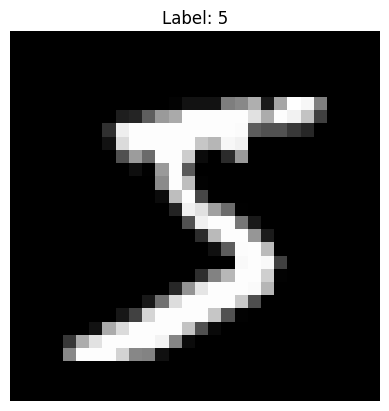

In [19]:
# Reshape the 0th index data to 28x28 pixels and display it
print(data.shape)
image_0 = data.iloc[0].values.reshape(28, 28)  # Convert to 28x28 array
plt.imshow(image_0, cmap='gray')  # Display in grayscale
plt.title(f"Label: {labels[0]}")  # Add the corresponding label as title
plt.axis('off')  # Hide axes for better visualization
plt.show()
